# DL in RL


In [ ]:
import gdown
import zipfile
import os
import pandas as pd

url = "https://drive.google.com/uc?export=download&id=10-Y0g0xurle5AexDKFyhVHiFGnzXfUYZ"
output = "DATA_RL_DL.zip"

gdown.download(url, output, quiet=False)

with zipfile.ZipFile(output, "r") as zip_ref:
    zip_ref.extractall("extracted_data")

p = "extracted_data/DATA_RL_DL/task"  # or 'extracted_data/DATA_RL_DL/add_task/'


def find_csv_files(directory):
    csv_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".csv"):
                csv_files.append(os.path.join(root, file))
    return csv_files


csv_files = find_csv_files(p)


Downloading...
From: https://drive.google.com/uc?export=download&id=10-Y0g0xurle5AexDKFyhVHiFGnzXfUYZ
To: /content/DATA_RL_DL.zip
100%|██████████| 8.36M/8.36M [00:00<00:00, 59.1MB/s]


Основное уравнение для Q learning
$$ Q(s,a) = r + \gamma\max_{a'}(Q(s',a')$$
Обновление состояний
$$ Q(s,a) =Q(s,a) + \alpha( r + \gamma\max_{a'}(Q(s',a') - Q(s,a))$$
В методе Q learning (в методах основанных на оценке стоимости), каждому значению s и a мы должны поставить в соответствие значение Q, т.е. получить таблицу соответсвий. Далее, основываясь на таблице соответствий мы сразу имеем оптимальную стратению. Если таких значений (размер таблицы) больше разумного, вычислительно очень трудно (или невозможно) сделать расчет всех значений Q. Наиболее эффективный способ это обойти - исользовать НС.  
Аппроксимация Q нейронной сетью: теперь Q зависит не только от пары (s,a) но также и от параметров НС w:
$$ Q(s,a,w) = r + \gamma\max_{a'}Q(s',a',w)$$
Ошибка (loss функция) для Q learning:
$$L = ( r + \gamma\max_{a'}Q(s',a',w) - Q(s,a,w))^2$$
Если мы будем вносить поправки в веса на основе текущей ошибки, то мы будем обновлять как занчение $Q(s',a',w)$ так и значение $Q(s,a,w)$. Но для наших методов, такой подход будет очень плохо работать (или совсем не работать), т.к. обновление $Q(s',a',w)$ происходит из прошлого, а наша задача обновиться из будущего (вся информация, которая нам нужна находится в будущем). По этому, делают следующую процедуру: создают нейросеть и дублируют ее. Одна нейросеть называется police, она обучется, вторая target - эта сеть с фиксированными весами. Через определенное количество эпох веса policy передаются в target.  
Перепишем ошибку с учетом того, что у нас 2 нейросети
$$L = ( r + \gamma\max_{a'}Q_{target}(s',a',w) - Q_{policy}(s,a,w))^2$$
Обновление весов $w_i$
$$ \Delta w_i = \frac{\partial L}{\partial w_i} = -2( r + \gamma\max_{a'}Q_{target}(s',a',w) - Q_{policy}(s,a,w))\frac{\partial Q_{policy}(s,a,w)}{\partial w_i} $$


Стратегия в произвольном месте клеточного мира

В итоге, агент с вероятностью почти 1 делает оптимальное действие

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import random
from collections import deque
import matplotlib.pyplot as plt


In [ ]:
data = pd.read_csv("extracted_data/DATA_RL_DL/task/BTC_1D.csv")
data["close_norm"] = data["close"] / data["close"].max()
prices = data["close_norm"].values
train_ratio = 0.8
train_size = int(len(prices) * train_ratio)
train_prices = prices[:train_size]
val_prices = prices[train_size:]

In [ ]:
class TradingEnv:
    def __init__(self, prices, window_size=10):
        self.prices = prices
        self.window_size = window_size
        self.current_step = 0
        self.initial_balance = 10  # стартовый баланс
        self.balance = self.initial_balance
        self.condition = self.initial_balance
        self.position = 0  # количество активов в руках
        self.done = False

    def reset(self):
        self.current_step = self.window_size - 1
        self.balance = self.initial_balance
        self.position = 0
        self.done = False
        return self._get_state()

    def _get_state(self):
        # Возвращает окно значений
        return self.prices[
            self.current_step - self.window_size + 1 : self.current_step + 1
        ]

    def step(self, action):
        current_price = self.prices[self.current_step]
        prev_condition = self.condition
        if action == 0:  # Покупка
            if self.position == 0:  # покупаем только если у нас нет позиции
                self.position += self.balance // current_price  # покупаем на все деньги
                self.balance = 0
        elif action == 1:  # Продажа
            if self.position > 0:  # продаем только если есть активы
                self.balance += self.position * current_price
                self.position = 0

        self.condition = self.balance + self.position * current_price
        reward = self.condition - prev_condition
        self.current_step += 1
        if self.current_step >= len(self.prices) - 1:
            self.done = True

        next_state = self._get_state()
        return next_state, reward, self.done, {}


In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, action_size, hidden_size=64):
        super(PolicyNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        x = torch.softmax(self.fc(lstm_out), dim=-1)
        return x


In [ ]:
class PolicyGradientAgent:
    def __init__(self, env, input_size, action_size, lr=0.005, device="cpu"):
        self.env = env
        self.device = device
        self.policy_net = PolicyNetwork(input_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.log_probs = []
        self.rewards = []

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).unsqueeze(-1).to(self.device)
        probs = self.policy_net(state)
        action_distribution = torch.distributions.Categorical(probs)
        action = action_distribution.sample()
        self.log_probs.append(action_distribution.log_prob(action))
        return action.item()

    def store_reward(self, reward):
        self.rewards.append(reward)

    def optimize(self):
        R = 0
        rewards = []
        for r in self.rewards[::-1]:
            R = r + 0.99 * R
            rewards.insert(0, R)
        rewards = torch.tensor(rewards).to(self.device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-9)

        loss = []
        for log_prob, reward in zip(self.log_probs, rewards):
            loss.append(-log_prob * reward)
        loss = torch.cat(loss).sum()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.log_probs = []
        self.rewards = []


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = TradingEnv(train_prices, window_size=10)
agent = PolicyGradientAgent(env, input_size=1, action_size=3, device=device)

EPISODES = 350
reward_history = []

for episode in range(EPISODES):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.store_reward(reward)
        total_reward += reward
        state = next_state

    agent.optimize()
    reward_history.append(total_reward)

    if episode % 10 == 0:
        print(f"Эпизод {episode}, Общая награда: {total_reward}")


Эпизод 0, Общая награда: 0.17634192900281853
Эпизод 10, Общая награда: 22.32316052424886
Эпизод 20, Общая награда: 17.919674144340043
Эпизод 30, Общая награда: -14.3816966202936
Эпизод 40, Общая награда: 34.75695857661703
Эпизод 50, Общая награда: -21.39147828639142
Эпизод 60, Общая награда: 2.7941783997442045
Эпизод 70, Общая награда: -17.68340657389199
Эпизод 80, Общая награда: 1.6916897376957003
Эпизод 90, Общая награда: 2.9408959381725897
Эпизод 100, Общая награда: -20.635193258157138
Эпизод 110, Общая награда: 13.216239959048336
Эпизод 120, Общая награда: 0.5901115345993819
Эпизод 130, Общая награда: 0.8818218575522936
Эпизод 140, Общая награда: -0.7359221371592817
Эпизод 150, Общая награда: -19.45055964095954
Эпизод 160, Общая награда: 10.865111414577942
Эпизод 170, Общая награда: 11.802527401548708
Эпизод 180, Общая награда: 17.48311300565518
Эпизод 190, Общая награда: 24.579702826529285
Эпизод 200, Общая награда: -39.06795387418142
Эпизод 210, Общая награда: 14.844156683559753


In [ ]:
def test_agent(agent, env, test_prices):
    """
    Тестирует агента на новых данных.

    Args:
        agent: Обученный агент (PolicyGradientAgent).
        env: Среда для торговли (TradingEnv).
        test_prices: Список цен для тестирования.

    Returns:
        total_reward: Общая награда за эпизод.
        balances: Список значений баланса на каждом шаге.
        actions: Список действий, предпринятых агентом.
    """
    # Создаем новую среду с тестовыми ценами
    env_test = TradingEnv(test_prices, window_size=env.window_size)
    state = env_test.reset()
    done = False

    total_reward = 0
    balances = [env_test.balance]
    actions = []
    rewards = []

    while not done:
        # Выбор действия агентом
        action = agent.select_action(state)
        actions.append(action)

        # Шаг в среде
        next_state, reward, done, _ = env_test.step(action)
        rewards.append(reward)
        total_reward += reward
        state = next_state

        # Сохраняем баланс
        balances.append(env_test.condition)

    # Визуализация результатов
    plt.figure(figsize=(12, 6))

    # График цен
    plt.subplot(2, 1, 1)
    plt.plot(test_prices, label="Цена актива", color="blue")
    plt.title("Динамика цены актива и действий агента")
    plt.xlabel("Шаг")
    plt.ylabel("Цена")

    action_markers = {0: "go", 1: "ro", 2: "bo"}  # Покупка, продажа, удержание
    action_labels = {0: "Покупка", 1: "Продажа", 2: "Удержание"}

    for i, action in enumerate(actions):
        # Отметка действия
        plt.plot(
            i + env_test.window_size,
            test_prices[i + env_test.window_size],
            action_markers[action],
        )

    # Создание легенды для маркеров
    purchase_patch = plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="g",
        markersize=10,
        label="Покупка",
    )
    sell_patch = plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="r",
        markersize=10,
        label="Продажа",
    )
    hold_patch = plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="b",
        markersize=10,
        label="Удержание",
    )

    plt.legend(handles=[purchase_patch, sell_patch, hold_patch])

    # График баланса
    plt.subplot(2, 1, 2)
    plt.plot(balances, label="Баланс", color="green")
    plt.title("Динамика баланса агента")
    plt.xlabel("Шаг")
    plt.ylabel("Баланс")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return total_reward, balances, actions


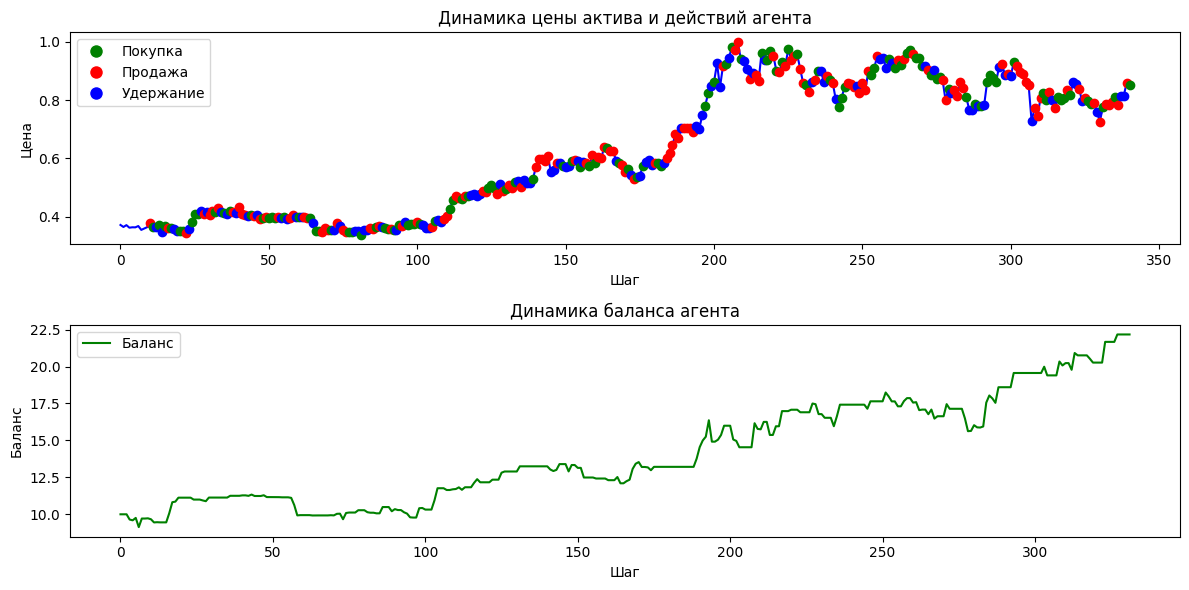

Общая награда на тестовом наборе: 12.170479917820561


In [ ]:
# Тестирование агента
total_reward, balances, actions = test_agent(agent, env, val_prices)

print(f"Общая награда на тестовом наборе: {total_reward}")
